# Histology Demo with Intel® Distribution of OpenVINO™ Toolkit. 

## Prerequisites
This sample requires the following:
- All files are present and in the following directory structure:
    
    - **histology.ipynb** - This Jupyter* Notebook
    - **data** - Directory to hold data
    - **python** -Directory for the Python scripts

## Introduction

This demo uses the [colorectal histology images dataset](https://www.tensorflow.org/datasets/catalog/colorectal_histology) to train a simple convolutional neural network in TensorFlow and demonstrates how to use OpenVINO™ integration with Tensorflow and OpenVINO™ Inference Engine to do inference on different Hardware architecture.

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow_datasets as tfds

print(tf.__version__)

2.7.0


In [2]:
from platform import python_version
print(python_version())

3.7.11


 ### Dataset Examples
 #### How to load TF colorrectal_histology dataset

In [3]:
os.environ['NO_GCE_CHECK'] = 'true'

In [4]:
(ds), ds_info =  tfds.load('colorectal_histology', data_dir=".", 
                                          shuffle_files=True, split='train', 
                                          with_info=True, as_supervised=True)

assert isinstance(ds, tf.data.Dataset)

#### Display a few examples from the dataset

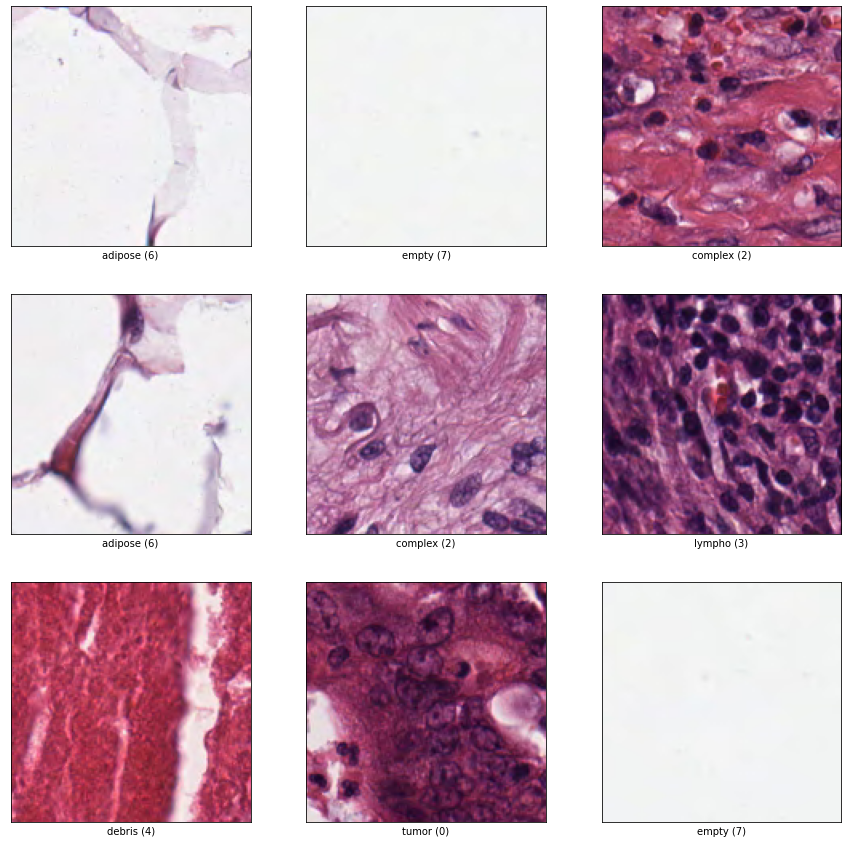

In [5]:
x_key, y_key = ds_info.supervised_keys
ds_temp = ds.map(lambda x, y: {x_key: x, y_key: y})
tfds.show_examples(ds_temp, ds_info, plot_scale=5);
!mkdir -p test_data

## Histology Demo
The Histology demo uses the Intel® Optimized Tensorflow to perform training and inference on input color rectal histology image dataset using OpenVINO™ integration with Tensorflow and Intel® Distribution of OpenVINO™ toolkit .  We will setup, train, run, and view the results for this application for several different hardware available on the compute nodes within the Intel® DevCloud for the Edge.  To accomplish this, we will be performing the following tasks:

1. Train the model in [Intel Optimized Tensorflow](https://software.intel.com/content/www/us/en/develop/tools/frameworks.html)
1. Run Inference using [OpenVINO™ Integration with Tensorflow](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/build/ovtfoverview.html)
2. Use the [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to create the inference model IR files needed to perform inference.
3. Use OpenVINO POT tool to quantize the FP32 model to INT8 model
4. View results and assess performance 

### Model training for the histology images
The following sections will go through the steps to run training on the current EC2 instance. 

#### [OPTIONAL FOR ISBI DEMO] Submit training job

In [ ]:
# ! bash ./training_job.sh colorectal_histology results/xeon/ice_lake 25 CPU 48

### Inference using OpenVINO™ Integration with Tensorflow and OpenVINO™ Inference Engine
The following sections will go through the steps to run inference application for a single image using OpenVINO integration with Tensorflow and if dataset on OpenVINO Inference Engine. For viewing the results from job please refer to section 4.5

#### Inference job for single image using OpenVINO™ Integration with Tensorflow

##### Submit  Inference job using OpenVINO™ Integration with Tensorflow
 
The inference workload will run on the CPU. It can be modified to schedule on another accelerator by passing the flag F as with a value of GPU, VPU, or VAD-M.
 
The workload images are expected to be in JPEG format. Any custom inputs need to be converted to JPEG before performing inference on them.

In [1]:
!chmod +x ./run_tensorflow_openvino.sh
! bash ./run_tensorflow_openvino.sh "CPU" 2>/dev/null | grep openvino

Inference time for using openvino Tensorflow in ms: 3.9980
Throughput for using openvino Tensorflow: 250.12 FPS


#### Convert the Tensorflow model to OpenVINO IR files
This workload is run on the CPU.

Run the following cell for Model Optimizer to create the model IR files. It converts the saved model trained from an edge Xeon Cascade Lake node to OpenVINO™ model format and saves it under `models/ov/<Model Precision>`. The model conversion can use either the generated savedModel or the frozen tensorflow model. Below mo_convert.sh script supports both model formats 

In [2]:
input_model="saved_model" 

In [3]:
!source mo_convert.sh $input_model 2>/dev/null | grep SUCCESS

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: /home/ubuntu/histology/models/ov/FP32/saved_model.xml
[ SUCCESS ] BIN file: /home/ubuntu/histology/models/ov/FP32/saved_model.bin
[ SUCCESS ] Total execution time: 5.96 seconds. 
[ SUCCESS ] Memory consumed: 1128 MB. 


In [4]:
input_model="frozen_model" 

In [5]:
!source mo_convert.sh $input_model 2>/dev/null | grep SUCCESS

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: /home/ubuntu/histology/models/ov/FP32/frozen_histology.xml
[ SUCCESS ] BIN file: /home/ubuntu/histology/models/ov/FP32/frozen_histology.bin
[ SUCCESS ] Total execution time: 4.38 seconds. 
[ SUCCESS ] Memory consumed: 684 MB. 


In [6]:
!echo "All IR files that were created:"
!find ./models/ov/FP32 -name "*.xml" -o -name "*.bin"

All IR files that were created:
./models/ov/FP32/frozen_histology.bin
./models/ov/FP32/frozen_histology.xml
./models/ov/FP32/saved_model.bin
./models/ov/FP32/saved_model.xml


#### Run inference on Histology Dataset via OpenVINO™ Inference Engine
The following cell runs our inference application for the Histology dataset and put the inference results into a txt file.

In [7]:
! chmod +x ./inference_job.sh
! bash ./inference_job.sh FP32 test_data/testdata.npz results/xeon/ice_lake/ CPU

2022-03-25 18:44:14.873380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/anaconda3/envs/histology_demo/lib/:
2022-03-25 18:44:14.873407: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Imported Python modules successfully.
{'device': 'CPU', 'input_data': 'test_data/testdata.npz', 'model': 'FP32', 'output': 'results/xeon/ice_lake/FP32', 'num_instance': '1'}
[ INFO ] Creating Inference Engine
[ INFO ] Reading data from test_data/testdata.npz
[ INFO ] Loading network:
	FP32
[ INFO ] Preparing input blobs
[ INFO ] Loading model to the plugin
[ INFO ] Write the prediction into the results/xeon/ice_lake/FP32/stats.txt file.


In [9]:
!find "results/xeon/ice_lake/FP32" -name "stats.txt"

results/xeon/ice_lake/FP32/stats.txt


## Quantization

Quantization is the process of reducing the model's precision. By performing this optimization, you can accelerate your model execution time.  

The [quantize.py](python/quantize.py) file contains quantization script and uses the [post training optimization toolkit (POT) API](https://docs.openvinotoolkit.org/latest/pot_compression_api_README.html) to reduce model's precision from FP32 to INT8. Quantization settings, such as the path to original model, path to dataset, quantization algorithm etc., which should be set via configs. ```DatasetsDataLoader``` creates quantization dataset from the sample video and loads one by one input images to POT, when quantization process starts. When quantization is finished, the INT8 model will be saved at ```'/models/ov/INT8'``` directory.

Run the following cell to do quantization. For Demo purpose this is not needed. 

In [27]:
# Run the quantization script
#!python ./python/quantize.py

23:13:40 accuracy_checker WARNING: /home/ubuntu/anaconda3/envs/histology_demo/lib/python3.7/site-packages/defusedxml/__init__.py:30: DeprecationWarning: defusedxml.cElementTree is deprecated, import from defusedxml.ElementTree instead.
  from . import cElementTree

23:13:40 accuracy_checker WARNING: /home/ubuntu/anaconda3/envs/histology_demo/lib/python3.7/site-packages/compression/algorithms/quantization/optimization/algorithm.py:30: UserWarning: Nevergrad package could not be imported. If you are planning to useany hyperparameter optimization algo, consider installing itusing pip. This implies advanced usage of the tool.Note that nevergrad is compatible only with Python 3.6+
  'Nevergrad package could not be imported. If you are planning to use'

23:13:40 accuracy_checker WARNING: /home/ubuntu/anaconda3/envs/histology_demo/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for al

In [43]:
tf_model_acc_list = !./run_tensorflow_inference_all.sh CPU 2>/dev/null | grep "Throughput" | awk -F ":" '{print $2}' | awk -F " " '{print $1}'
tf_model_type = ['Native Tensorflow', 'Tensorflow with oneDNN', 'OpenVINO Tensorflow']
print(tf_model_acc_list)

['82.32', '81.11', '266.67']


In [49]:
ov_model_acc_list = !./benchmark_job.sh  | grep "Throughput" | awk -F ":" '{print $2}' | awk -F " " '{print $1}'
ov_model_type = ['OpenVINO FP32', 'OpenVINO INT8']
print(ov_model_acc_list)

['406.48', '1892.74']


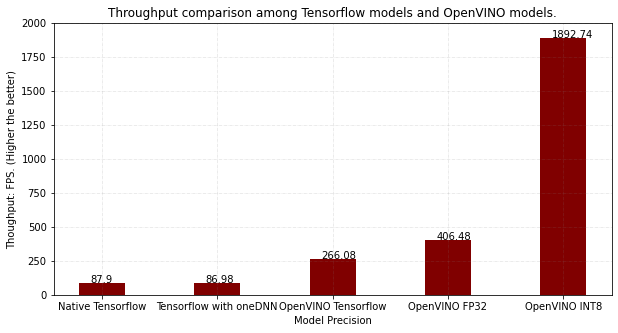

In [55]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i-0.1,y[i]+1,y[i])
        
model_type = tf_model_type + ov_model_type
acc = [float(f) for f in tf_model_acc_list + ov_model_acc_list]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(model_type, acc, color ='maroon',
        width = 0.4)
addlabels(model_type, acc) 
plt.xlabel("Model Precision")
plt.ylabel("Thoughput: FPS. (Higher the better)")
plt.ylim([0,2000])
plt.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.3)
plt.title("Throughput comparison among Tensorflow models and OpenVINO models.")
plt.show()

### Inferencing accuracy comparison between FP32 model and INT8 model

The output classification results for each job is written to the file `stats_<*job id*>.txt` located in the directory `results/<device>` that was specified as the output directory to the job file. Each line of the result txt file records the following information:

`index of the testing image, true class label, predicted class label`

Example of how to view the inferencing results are shown below. The overall accuracy is also shown below. 


In [15]:
! chmod +x ./inference_job.sh
! bash ./inference_job.sh INT8 test_data/testdata.npz results/xeon/ice_lake/ CPU

2022-03-25 19:00:20.838675: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/anaconda3/envs/histology_demo/lib/:
2022-03-25 19:00:20.838699: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Imported Python modules successfully.
{'device': 'CPU', 'input_data': 'test_data/testdata.npz', 'model': 'INT8', 'output': 'results/xeon/ice_lake/INT8', 'num_instance': '1'}
[ INFO ] Creating Inference Engine
[ INFO ] Reading data from test_data/testdata.npz
[ INFO ] Loading network:
	INT8
[ INFO ] Preparing input blobs
[ INFO ] Loading model to the plugin
[ INFO ] Write the prediction into the results/xeon/ice_lake/INT8/stats.txt file.


In [18]:
#For viewing accuracy
def calc_accuracy(result_file, precision):
    with open(result_file, 'r') as f:
        preds = f.readlines()
        count = len(preds)
        true_count = 0
        for line in preds:
            line=line.rstrip().split(",")
            if line[1] == line[2]:
                true_count += 1
    print("Accuracy of the {0} model is {1:.4f}.".format(precision, true_count*1.0/count))
    return(true_count*1.0/count)

fp32_acc = calc_accuracy("results/xeon/ice_lake/FP32/stats.txt", "FP32")    
int8_acc = calc_accuracy("results/xeon/ice_lake/INT8/stats.txt", "INT8")

Accuracy of the FP32 model is 0.8320.
Accuracy of the INT8 model is 0.8300.


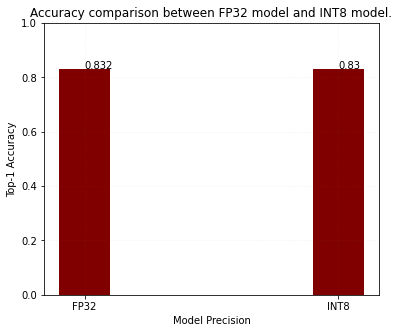

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

model_type = ["FP32", "INT8"]
acc = [fp32_acc, int8_acc]

fig = plt.figure(figsize = (6, 5))
 
# creating the bar plot
plt.bar(model_type, acc, color ='maroon',
        width = 0.2)
addlabels(model_type, acc) 
plt.xlabel("Model Precision")
plt.ylabel("Top-1 Accuracy")
plt.ylim([0,1])
plt.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.1)
plt.title("Accuracy comparison between FP32 model and INT8 model.")
plt.show()